# Lets predict Body performance using multi class classification and learn how to use calibrated classifer on multi class data


Import Section 


In [37]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from  sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,log_loss,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')
import operator
import copy
import json
import pickle
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV,HalvingGridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV,calibration_curve

Lets Pull Heart Failure Data from Kaggle

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!mkdir bodydataset
!kaggle datasets download -d kukuroo3/body-performance-data
!unzip body-performance-data.zip -d bodydataset

Saving kaggle.json to kaggle.json
  0% 0.00/249k [00:00<?, ?B/s]
100% 249k/249k [00:00<00:00, 57.2MB/s]
Archive:  body-performance-data.zip
  inflating: bodydataset/bodyPerformance.csv  


Lets Create Result Dataset for evaluation

In [61]:
result_dataset = pd.DataFrame(data =np.zeros((3,14)) , index = ['accuracy_score','f1_score','log_loss'],columns = ['KNN','KNN_calib','NB','NB_calib','LR','LR_calib','SVC','SVC_calib','DT','DT_calib','RF','RF_calib','GBDT','GBDT_calib'])
result_dataset

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


metrics function for metric calculation

In [80]:
def metrics(classfier,X_test,y_test,name):
  y_pred = classfier.predict(X_test)
  y_prob = classfier.predict_proba(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  logloss = log_loss(y_test,y_prob,labels= [0,1,2,3])
  f1score = f1_score(y_test,y_pred,average='weighted')
  result_dataset[name]['accuracy_score'] = accuracy
  result_dataset[name]['f1_score'] = f1score
  result_dataset[name]['log_loss'] = logloss
  print("accuracy score :",accuracy)
  print("f1 score :",f1score)
  print("log loss :",logloss)
  print('classification report : \n', classification_report(y_test,y_pred))
  print('*********** confusion matrx ***********')
  sns.heatmap(confusion_matrix(y_test,y_pred),annot = True, cmap = 'Blues',fmt = '.2f')
  plt.show()

lets load and analyse the dataset

In [40]:
dataset = pd.read_csv('/content/bodydataset/bodyPerformance.csv')
dataset.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


Lets understand basic facts of the dataset

In [41]:
dataset['class'].value_counts()

C    3349
D    3349
A    3348
B    3347
Name: class, dtype: int64

null values

In [42]:
dataset.isnull().sum()

age                        0
gender                     0
height_cm                  0
weight_kg                  0
body fat_%                 0
diastolic                  0
systolic                   0
gripForce                  0
sit and bend forward_cm    0
sit-ups counts             0
broad jump_cm              0
class                      0
dtype: int64

In [43]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


lets describe the dataset

In [44]:
dataset.describe()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
count,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000
mean,36.775106,168.559807,67.447316,23.240165,78.796842,130.234817,36.963877,15.209268,39.771224,190.129627
std,13.625639,8.426583,11.949666,7.256844,10.742033,14.713954,10.624864,8.456677,14.276698,39.868000
min,21.000000,125.000000,26.300000,3.000000,0.000000,0.000000,0.000000,-25.000000,0.000000,0.000000
25%,25.000000,162.400000,58.200000,18.000000,71.000000,120.000000,27.500000,10.900000,30.000000,162.000000
50%,32.000000,169.200000,67.400000,22.800000,79.000000,130.000000,37.900000,16.200000,41.000000,193.000000
75%,48.000000,174.800000,75.300000,28.000000,86.000000,141.000000,45.200000,20.700000,50.000000,221.000000
max,64.000000,193.800000,138.100000,78.400000,156.200000,201.000000,70.500000,213.000000,80.000000,303.000000


Observations:

* No null values.
* All classes are well balanced.
* Number of records 13393.
* Numerical columns
  - age	
  - height_cm	
  - weight_kg	
  - body fat_%	
  - diastolic	
  - systolic	
  - gripForce	
  - sit and bend forward_cm	
  - sit-ups counts	
  - broad jump_cm	
* Categorical columns
  - gender	
* Target 
  - class


### Univariate Analysis

In [45]:
def plots_numerical(datas='Age'):
    print()
    print()
    print("*"*100)
    print("*"* 50 + datas + "*"* 50)
    print("*"*100)
    print()
    mesh_fig,axes = plt.subplots(2,2,figsize=(15, 10))
    sns.scatterplot(data=dataset,x=datas,y='class',hue='class', ax=axes[0,0])
    axes[0,0].set_title('scatter plot')
    sns.violinplot(data=dataset, y=datas,x = 'class', ax=axes[0,1] )
    axes[0,1].set_title('violin_plot')
    sns.set_theme(style="whitegrid")
    sns.kdeplot(data=dataset, x=datas,hue = "class",ax = axes[1,0])
    axes[1,0].set_title('CDF plot')
    sns.boxplot(data=dataset, y=datas,x="class",ax = axes[1,1])
    axes[1,1].set_title('box plot')
    plt.show()




****************************************************************************************************
**************************************************age**************************************************
****************************************************************************************************



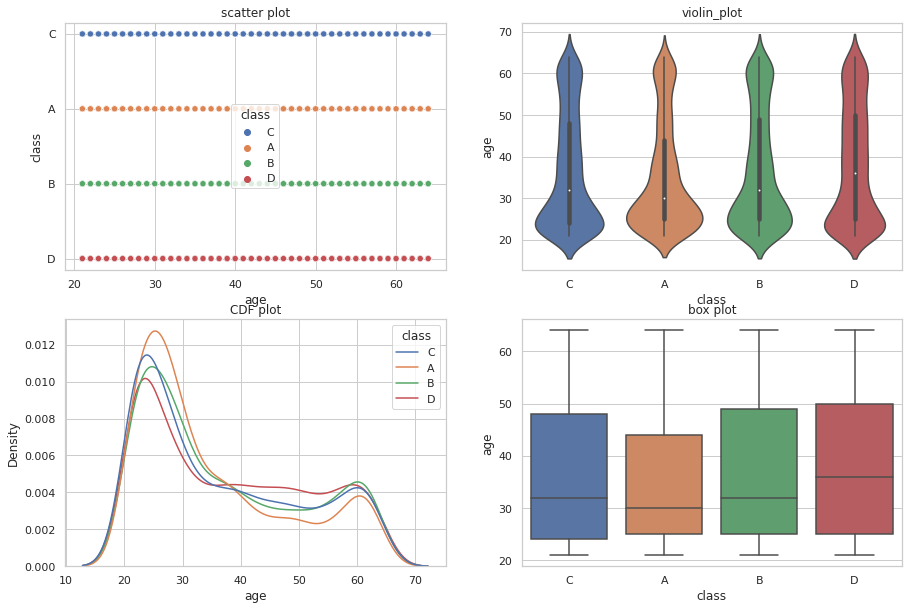



****************************************************************************************************
**************************************************height_cm**************************************************
****************************************************************************************************



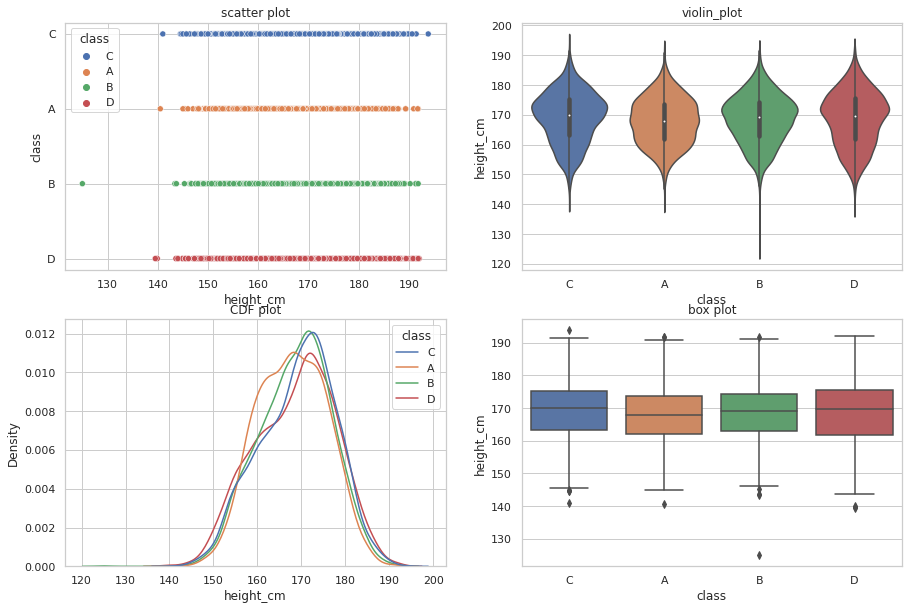



****************************************************************************************************
**************************************************weight_kg**************************************************
****************************************************************************************************



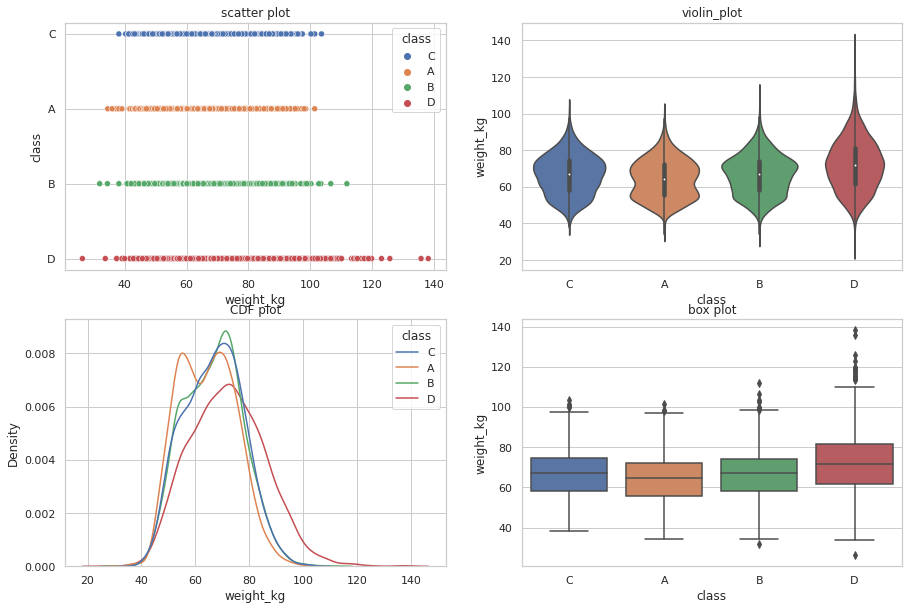



****************************************************************************************************
**************************************************body fat_%**************************************************
****************************************************************************************************



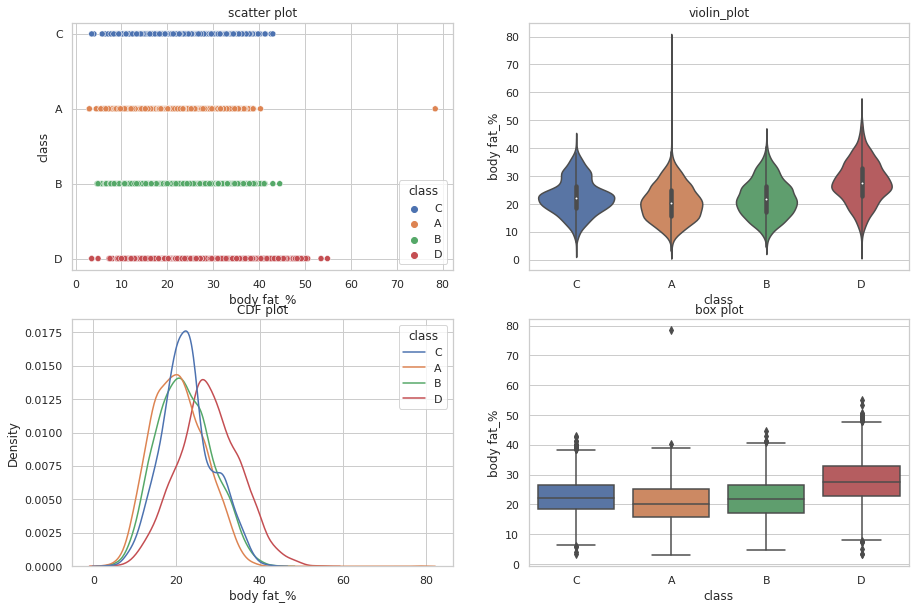



****************************************************************************************************
**************************************************diastolic**************************************************
****************************************************************************************************



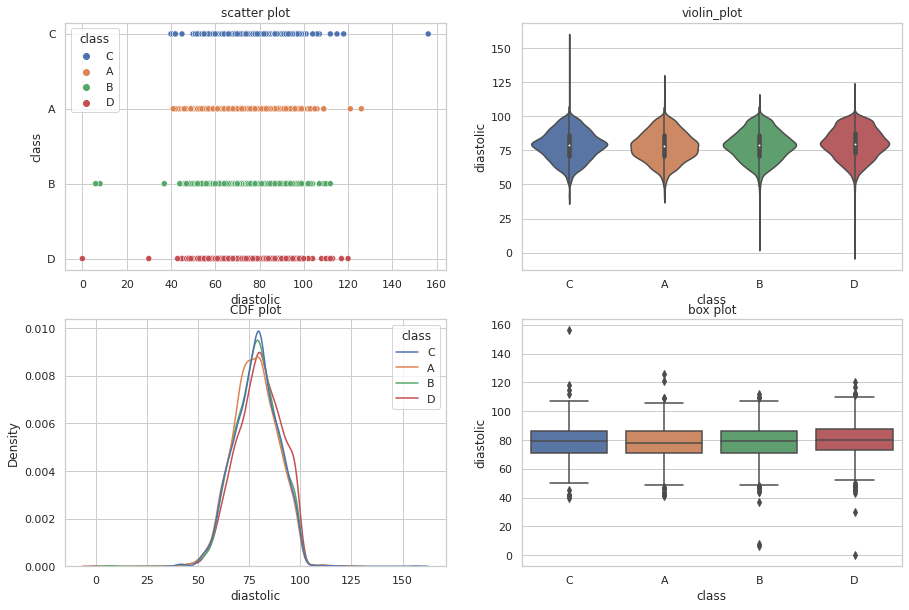



****************************************************************************************************
**************************************************systolic**************************************************
****************************************************************************************************



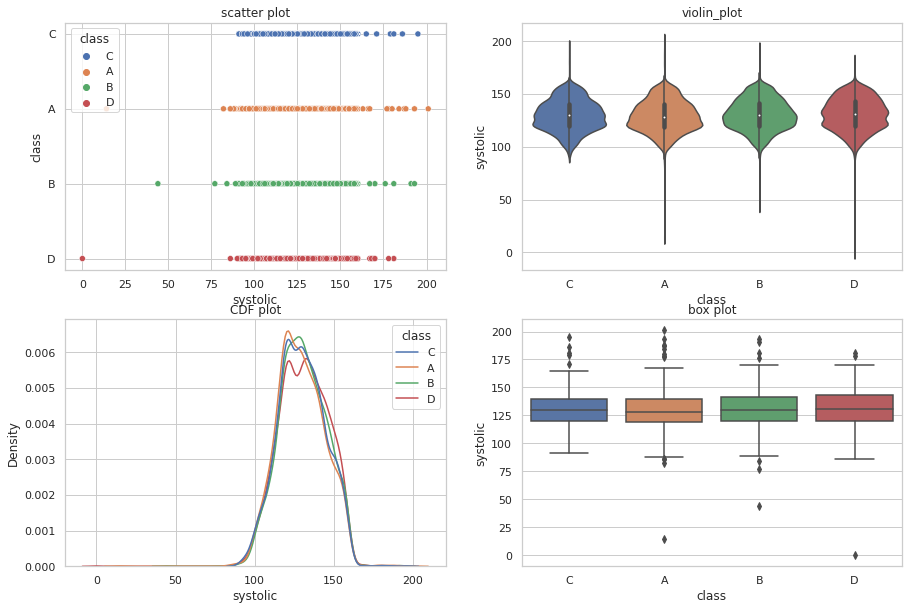



****************************************************************************************************
**************************************************gripForce**************************************************
****************************************************************************************************



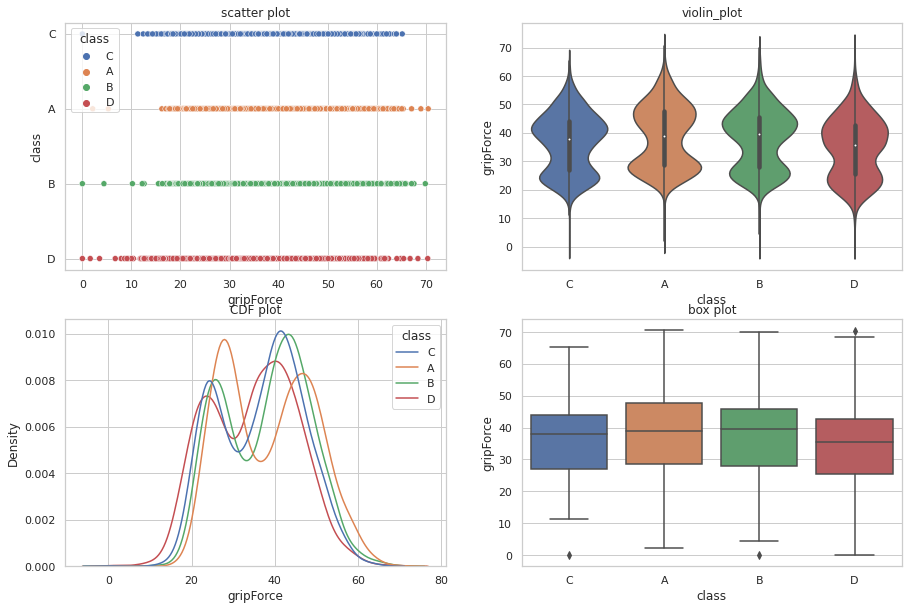



****************************************************************************************************
**************************************************sit and bend forward_cm**************************************************
****************************************************************************************************



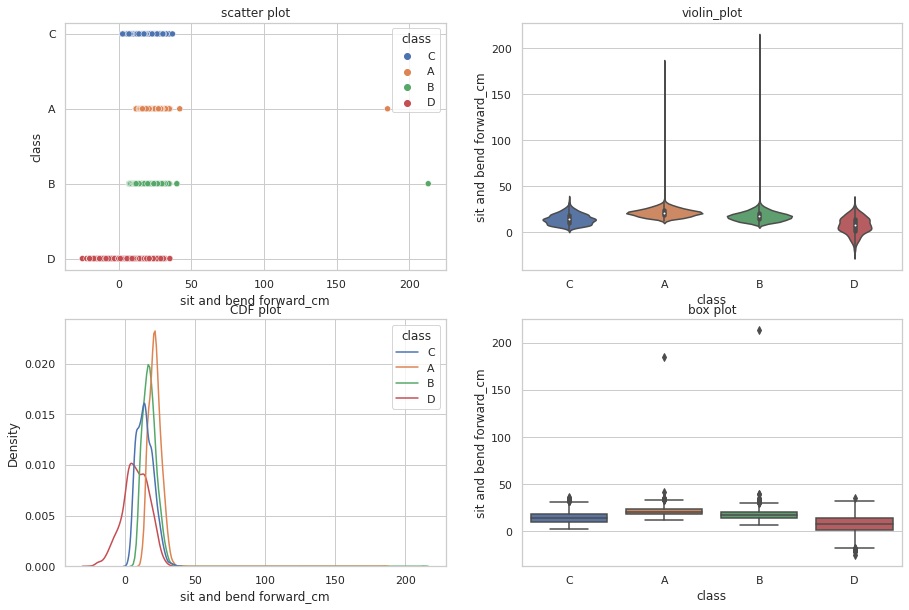



****************************************************************************************************
**************************************************sit-ups counts**************************************************
****************************************************************************************************



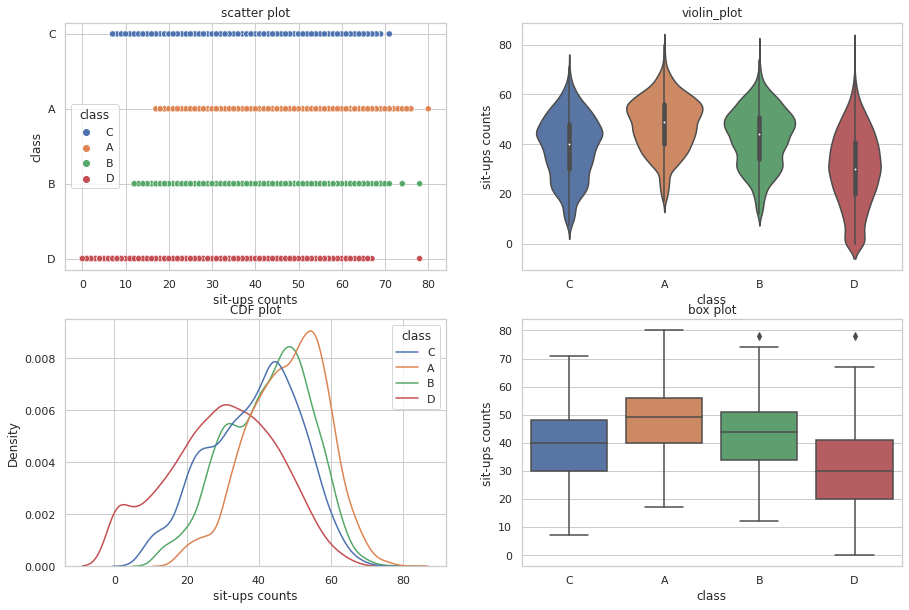



****************************************************************************************************
**************************************************broad jump_cm**************************************************
****************************************************************************************************



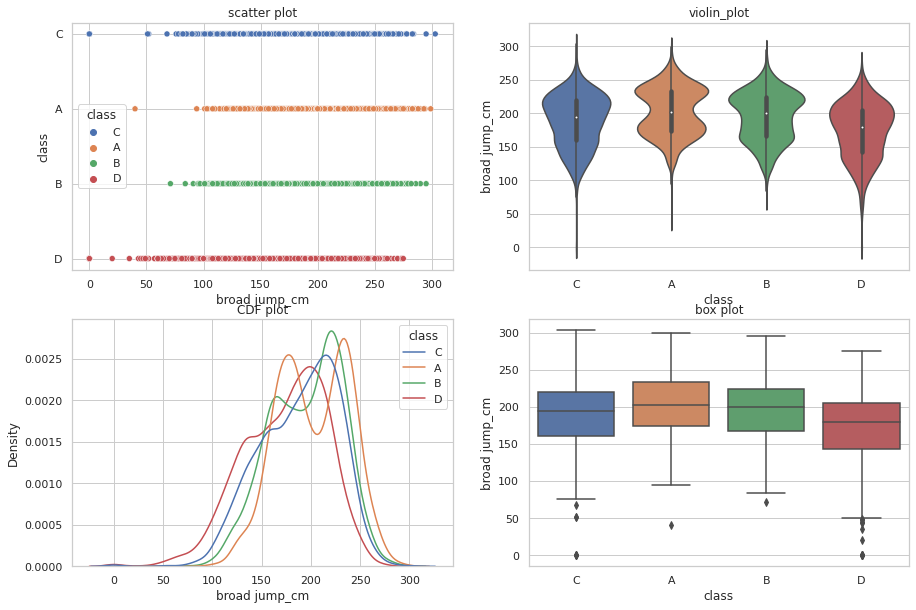

In [46]:
for value in ['age','height_cm','weight_kg','body fat_%','diastolic','systolic','gripForce','sit and bend forward_cm','sit-ups counts','broad jump_cm']:
  plots_numerical(value)


In [47]:
def plots_categorical(datas='gender'):
    print()
    print()
    print("*"*100)
    print("*"* 50 + 'Count Plot for ' + datas + "*"* 50)
    print("*"*100)
    print()
    sns.countplot(data=dataset, x=datas,hue = 'class')
    plt.show()



****************************************************************************************************
**************************************************Count Plot for gender**************************************************
****************************************************************************************************



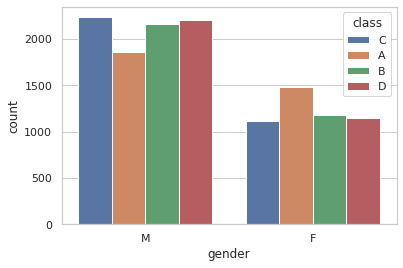

In [48]:
for value in ['gender']:
  plots_categorical(value)

Observations:

* sit and bend forward cms and sit up counts looks useful.
* remaining all have similar distributions for class.

### Bi-Variate Analysis

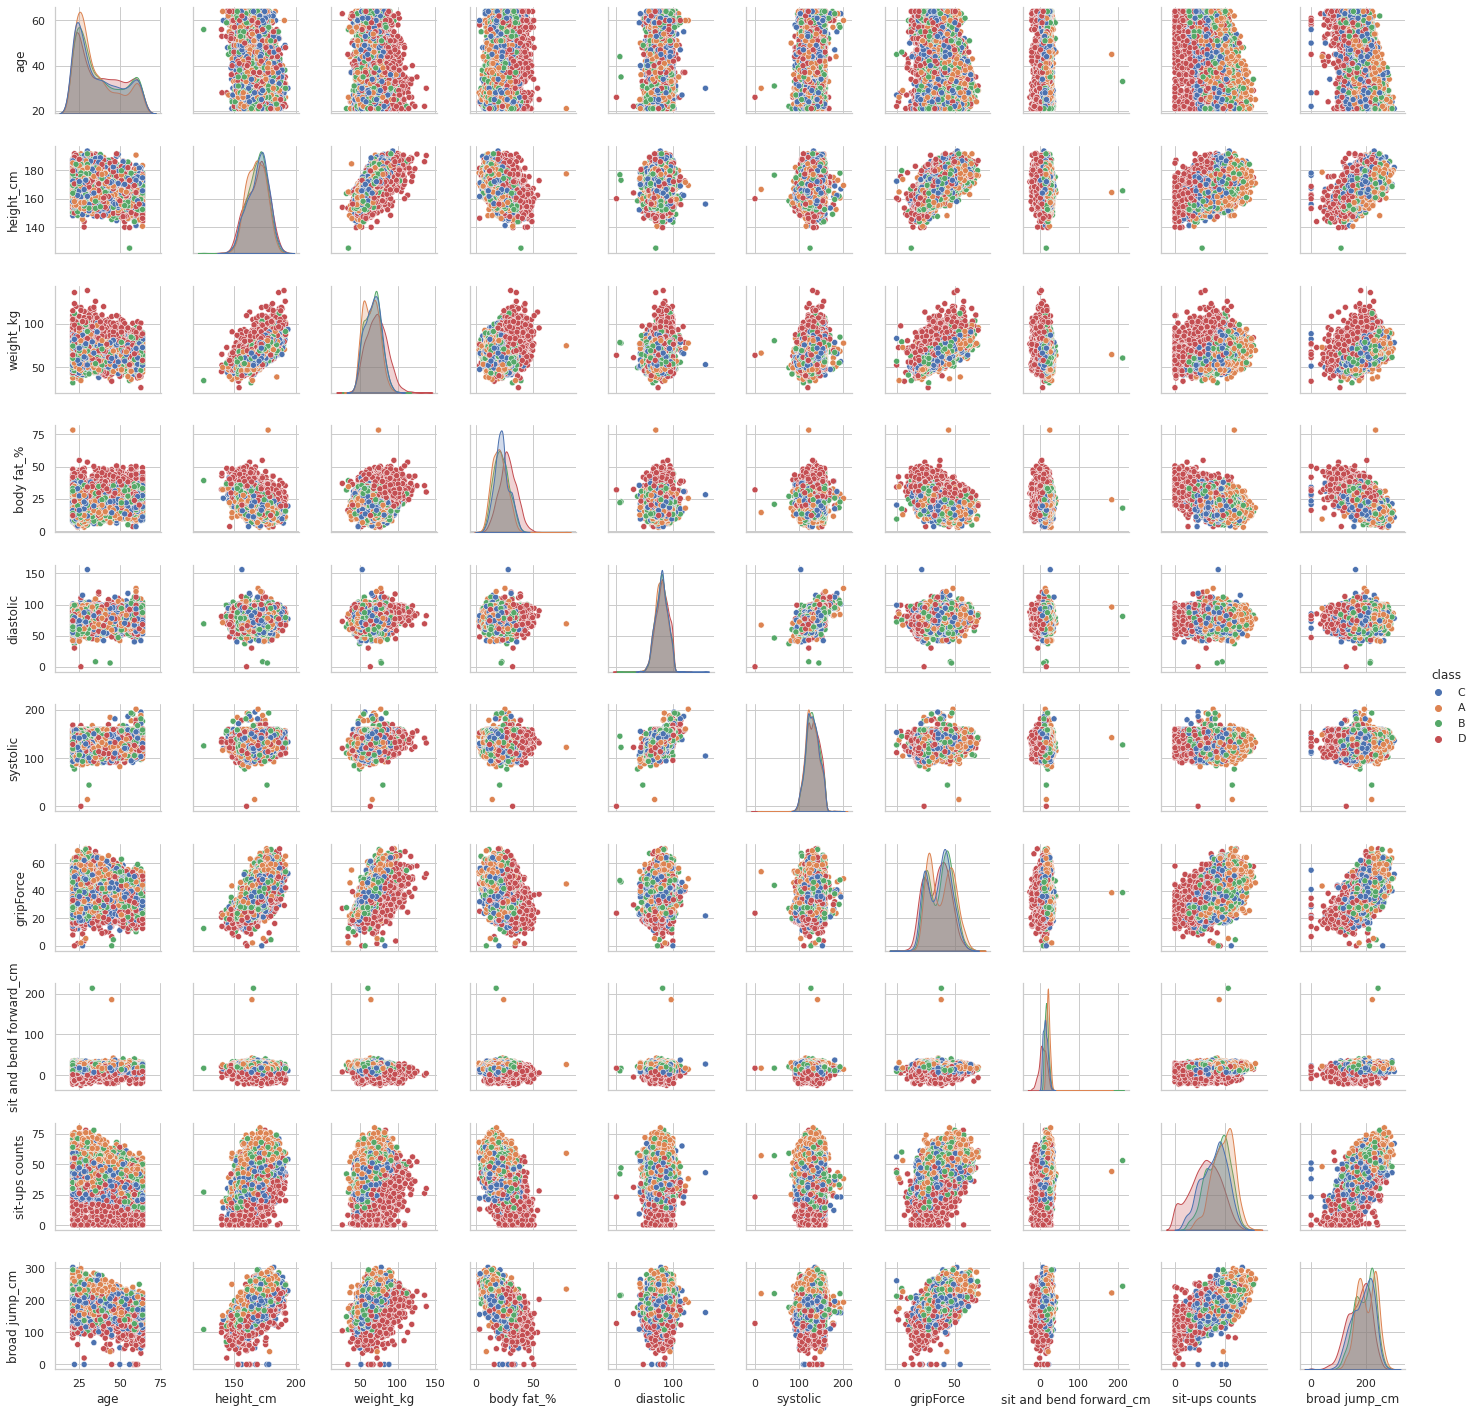

In [49]:
plt.close();
sns.set_style("whitegrid");
sns.pairplot(dataset, hue="class", height=2);
plt.show()

Observations 

* We can see good dispersion of data classes hence good possiblity of gettting high score with linear models in high dimesnions. 

### Preprocessing

Lets map target to numericals

In [64]:
dataset['class'] = dataset['class'].map({'A':0,'B':1,'C':3,'D':4})

In [65]:
dataset['class']

0        3
1        0
2        3
3        1
4        1
        ..
13388    3
13389    4
13390    0
13391    4
13392    3
Name: class, Length: 13393, dtype: int64

#### Train Test Split with 80 and 20 

In [66]:
X_train , X_test,y_train,y_test = train_test_split(dataset.iloc[:,:-1],dataset.iloc[:,[-1]],test_size = 0.2,random_state = 42,stratify = dataset.iloc[:,[-1]])
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10714, 11)
(2679, 11)
(10714, 1)
(2679, 1)


In [67]:
X_train.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
0,28.0,M,179.5,75.0,15.3,85.0,135.0,45.0,10.0,50.0,210.0
1,29.0,M,172.7,71.8,15.7,86.0,148.0,52.2,19.7,57.0,254.0
2,39.0,M,177.7,68.6,19.1,87.0,147.0,40.4,2.8,44.0,240.0
3,43.0,F,156.4,50.0,19.3,73.0,123.0,32.4,23.8,34.0,175.0
4,23.0,M,170.8,60.3,11.5,88.0,129.0,38.9,20.1,45.0,232.0


lets create a column transformer for gender one hot encoding

In [68]:
gender_onehot =ColumnTransformer([('genderencoding', OneHotEncoder(handle_unknown = 'ignore'), ['gender']),('remaining_scaling',StandardScaler(),['age','height_cm','weight_kg','body fat_%','diastolic','systolic','gripForce','sit and bend forward_cm','sit-ups counts','broad jump_cm'])], remainder='passthrough')
gender_onehot.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('genderencoding',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['gender']),
                                ('remaining_scaling', StandardScaler(),
                                 ['age', 'height_cm', 'weight_kg', 'body fat_%',
                                  'diastolic', 'systolic', 'gripForce',
                                  'sit and bend forward_cm', 'sit-ups counts',
                                  'broad jump_cm'])])

### Lets start with KNN

In [69]:
knn_params = {'model__n_neighbors' : [23,24,25,26,27],'gender_onehot__remaining_scaling__with_mean' : [True, False]}
knn_pipe = Pipeline([('gender_onehot', gender_onehot),('model', KNeighborsClassifier())])
knn_grid = GridSearchCV(estimator=knn_pipe, param_grid=knn_params)
knn_grid.fit(X_train, y_train)
knn_grid.best_estimator_

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model', KNeighborsC

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model', KNeighborsClassifier(n_neighbors=25))])

Lets see model performance

accuracy score : 0.6293393057110862
f1 score : 0.6297681601880716
log loss : 2.419871571505186
classification report : 
               precision    recall  f1-score   support

           0       0.61      0.85      0.71       670
           1       0.49      0.49      0.49       669
           3       0.58      0.53      0.56       670
           4       0.93      0.64      0.76       670

    accuracy                           0.63      2679
   macro avg       0.65      0.63      0.63      2679
weighted avg       0.65      0.63      0.63      2679

*********** confusion matrx ***********


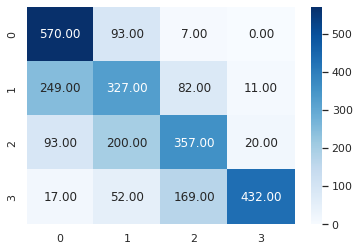

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.629339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.629768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,2.419872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
metrics(knn_grid.best_estimator_,X_test,y_test,'KNN')
result_dataset

KNN_With_Calibration

In [ ]:
knn_calib_params = {'model__method' : ['sigmoid', 'isotonic'],'model__base_estimator__n_neighbors' : [23,24,25,26,27],'gender_onehot__remaining_scaling__with_mean' : [True, False]}
knn_calib_pipe = Pipeline([('gender_onehot', gender_onehot),('model', CalibratedClassifierCV(KNeighborsClassifier()))])
knn_calib_grid = GridSearchCV(estimator=knn_calib_pipe, param_grid=knn_calib_params,verbose = 2)
knn_calib_grid.fit(X_train, y_train)
knn_calib_grid.best_estimator_

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
                 CalibratedClassifierCV(base_estimator=KNeighborsClassifier(n_neighbors=27),
                                        method='isotonic'))])

accuracy score : 0.6573348264277715
f1 score : 0.6547723291188613
log loss : 0.9784136458355387
classification report : 
               precision    recall  f1-score   support

           0       0.64      0.83      0.72       670
           1       0.52      0.47      0.49       669
           3       0.62      0.57      0.59       670
           4       0.87      0.76      0.81       670

    accuracy                           0.66      2679
   macro avg       0.66      0.66      0.65      2679
weighted avg       0.66      0.66      0.65      2679

*********** confusion matrx ***********


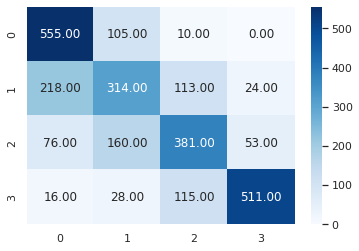

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.629339,0.657335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.629768,0.654772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,2.419872,0.978414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
metrics(knn_calib_grid.best_estimator_,X_test,y_test,'KNN_calib')
result_dataset

### Lets Apply NB

In [86]:
NB_params = {'model__var_smoothing' : np.logspace(0,-9, num=10)}
NB_pipe = Pipeline([('gender_onehot', gender_onehot),('model', GaussianNB())])
NB_grid = GridSearchCV(estimator=NB_pipe, param_grid=NB_params)
NB_grid.fit(X_train, y_train)
NB_grid.best_estimator_

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model', GaussianNB(

accuracy score : 0.53826054497947
f1 score : 0.5235419939852661
log loss : 1.1110816329980608
classification report : 
               precision    recall  f1-score   support

           0       0.57      0.75      0.65       670
           1       0.41      0.29      0.34       669
           3       0.48      0.42      0.45       670
           4       0.63      0.70      0.66       670

    accuracy                           0.54      2679
   macro avg       0.52      0.54      0.52      2679
weighted avg       0.52      0.54      0.52      2679

*********** confusion matrx ***********


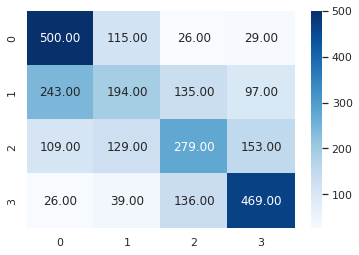

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.629339,0.657335,0.538261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.629768,0.654772,0.523542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,2.419872,0.978414,1.111082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
metrics(NB_grid.best_estimator_,X_test,y_test,'NB')
result_dataset

## Lets Use NB calibration

In [ ]:
NB_calib_params = {'model__method' : ['sigmoid', 'isotonic'],'model__base_estimator__var_smoothing' : np.logspace(0,-9, num=10)}
NB_calib_pipe = Pipeline([('gender_onehot', gender_onehot),('model', CalibratedClassifierCV(GaussianNB()))])
NB_calib_grid = GridSearchCV(estimator=NB_calib_pipe, param_grid=NB_calib_params,verbose = 2)
NB_calib_grid.fit(X_train, y_train)
NB_calib_grid.best_estimator_

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
                 CalibratedClassifierCV(base_estimator=GaussianNB(var_smoothing=0.01),
                                        method='isotonic'))])

accuracy score : 0.541993281075028
f1 score : 0.52525643614734
log loss : 1.056237536802744
classification report : 
               precision    recall  f1-score   support

           0       0.57      0.76      0.65       670
           1       0.42      0.29      0.34       669
           3       0.49      0.41      0.44       670
           4       0.61      0.71      0.66       670

    accuracy                           0.54      2679
   macro avg       0.53      0.54      0.53      2679
weighted avg       0.53      0.54      0.53      2679

*********** confusion matrx ***********


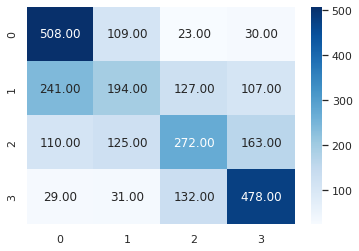

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.629339,0.657335,0.538261,0.541993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.629768,0.654772,0.523542,0.525256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,2.419872,0.978414,1.111082,1.056238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
metrics(NB_calib_grid.best_estimator_,X_test,y_test,'NB_calib')
result_dataset

### Lets use logistic regresson

In [90]:
LR_params = {'model__C': [0.0001, 0.01, 1.0, 10.0,100.0, 1000.0]}
LR_pipe = Pipeline([('gender_onehot', gender_onehot),('model', LogisticRegression())])
LR_grid = GridSearchCV(estimator=LR_pipe, param_grid=LR_params)
LR_grid.fit(X_train, y_train)
LR_grid.best_estimator_

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model', LogisticReg

accuracy score : 0.6267263904441956
f1 score : 0.6238355062946571
log loss : 1.0095601234297196
classification report : 
               precision    recall  f1-score   support

           0       0.68      0.75      0.71       670
           1       0.49      0.46      0.47       669
           3       0.54      0.52      0.53       670
           4       0.78      0.78      0.78       670

    accuracy                           0.63      2679
   macro avg       0.62      0.63      0.62      2679
weighted avg       0.62      0.63      0.62      2679

*********** confusion matrx ***********


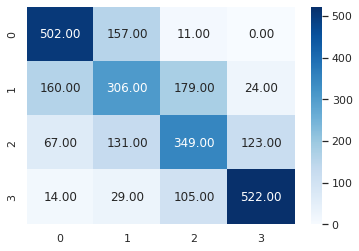

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.629339,0.657335,0.538261,0.541993,0.626726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.629768,0.654772,0.523542,0.525256,0.623836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,2.419872,0.978414,1.111082,1.056238,1.009560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
metrics(LR_grid.best_estimator_,X_test,y_test,'LR')
result_dataset

## Lets Use NB calibration

In [92]:
LR_calib_params = {'model__method' : ['sigmoid', 'isotonic'],'model__base_estimator__C': [0.0001, 0.01, 1.0, 10.0,100.0, 1000.0]}
LR_calib_pipe = Pipeline([('gender_onehot', gender_onehot),('model', CalibratedClassifierCV(LogisticRegression()))])
LR_calib_grid = GridSearchCV(estimator=LR_calib_pipe, param_grid=LR_calib_params,verbose = 2)
LR_calib_grid.fit(X_train, y_train)
LR_calib_grid.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END model__base_estimator__C=0.0001, model__method=sigmoid; total time=   0.6s
[CV] END model__base_estimator__C=0.0001, model__method=sigmoid; total time=   0.6s
[CV] END model__base_estimator__C=0.0001, model__method=sigmoid; total time=   0.6s
[CV] END model__base_estimator__C=0.0001, model__method=sigmoid; total time=   0.7s
[CV] END model__base_estimator__C=0.0001, model__method=sigmoid; total time=   0.7s
[CV] END model__base_estimator__C=0.0001, model__method=isotonic; total time=   0.5s
[CV] END model__base_estimator__C=0.0001, model__method=isotonic; total time=   0.5s
[CV] END model__base_estimator__C=0.0001, model__method=isotonic; total time=   0.5s
[CV] END model__base_estimator__C=0.0001, model__method=isotonic; total time=   0.5s
[CV] END model__base_estimator__C=0.0001, model__method=isotonic; total time=   0.5s
[CV] END model__base_estimator__C=0.01, model__method=sigmoid; total time=   1.2s
[CV] END mod

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
           

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
                 CalibratedClassifierCV(base_estimator=GaussianNB(var_smoothing=0.01),
                                        method='isotonic'))])

accuracy score : 0.6211272863008586
f1 score : 0.6062530225937186
log loss : 0.9275472604355547
classification report : 
               precision    recall  f1-score   support

           0       0.61      0.87      0.72       670
           1       0.52      0.39      0.45       669
           3       0.55      0.43      0.48       670
           4       0.76      0.79      0.78       670

    accuracy                           0.62      2679
   macro avg       0.61      0.62      0.61      2679
weighted avg       0.61      0.62      0.61      2679

*********** confusion matrx ***********


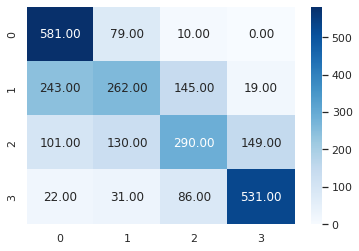

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.629339,0.657335,0.538261,0.541993,0.626726,0.621127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.629768,0.654772,0.523542,0.525256,0.623836,0.606253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,2.419872,0.978414,1.111082,1.056238,1.009560,0.927547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
metrics(LR_calib_grid.best_estimator_,X_test,y_test,'LR_calib')
result_dataset

### Lets use SVC

In [96]:
SVC_params = {'model__C': [0.0001, 0.01, 1.0],'model__kernel' : ['poly', 'rbf']}
SVC_pipe = Pipeline([('gender_onehot', gender_onehot),('model', SVC(probability = True))])
SVC_grid = GridSearchCV(estimator=SVC_pipe, param_grid=SVC_params,cv = 2,verbose = 2)
SVC_grid.fit(X_train, y_train)
SVC_grid.best_estimator_

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END ................model__C=0.0001, model__kernel=poly; total time=  12.6s
[CV] END ................model__C=0.0001, model__kernel=poly; total time=  12.6s
[CV] END .................model__C=0.0001, model__kernel=rbf; total time=  19.6s
[CV] END .................model__C=0.0001, model__kernel=rbf; total time=  19.6s
[CV] END ..................model__C=0.01, model__kernel=poly; total time=  10.2s
[CV] END ..................model__C=0.01, model__kernel=poly; total time=  10.5s
[CV] END ...................model__C=0.01, model__kernel=rbf; total time=  17.4s
[CV] END ...................model__C=0.01, model__kernel=rbf; total time=  17.4s
[CV] END ...................model__C=1.0, model__kernel=poly; total time=   6.9s
[CV] END ...................model__C=1.0, model__kernel=poly; total time=   7.0s
[CV] END ....................model__C=1.0, model__kernel=rbf; total time=  11.2s
[CV] END ....................model__C=1.0, model_

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model', SVC(probabi

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model', SVC(probability=True))])

In [99]:
SVC_grid.best_params_

{'model__C': 1.0, 'model__kernel': 'rbf'}

accuracy score : 0.6969018290406869
f1 score : 0.6978387848876013
log loss : 0.9824737523144427
classification report : 
               precision    recall  f1-score   support

           0       0.69      0.82      0.75       670
           1       0.56      0.56      0.56       669
           3       0.68      0.64      0.66       670
           4       0.90      0.76      0.82       670

    accuracy                           0.70      2679
   macro avg       0.70      0.70      0.70      2679
weighted avg       0.70      0.70      0.70      2679

*********** confusion matrx ***********


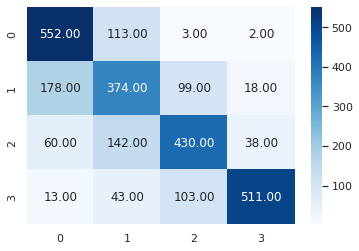

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.629339,0.657335,0.538261,0.541993,0.626726,0.621127,0.696902,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.629768,0.654772,0.523542,0.525256,0.623836,0.606253,0.697839,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,2.419872,0.978414,1.111082,1.056238,1.009560,0.927547,0.982474,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
metrics(SVC_grid.best_estimator_,X_test,y_test,'SVC')
result_dataset

## Lets Use SVC calibration

In [101]:
SVC_calib_params = {'model__method' : ['sigmoid', 'isotonic'],'model__base_estimator__C': [ 1.0],'model__base_estimator__kernel' : ['rbf']}
SVC_calib_pipe = Pipeline([('gender_onehot', gender_onehot),('model', CalibratedClassifierCV(SVC(probability = True)))])
SVC_calib_grid = GridSearchCV(estimator=SVC_calib_pipe, param_grid=SVC_calib_params,cv = 2,verbose = 2)
SVC_calib_grid.fit(X_train, y_train)
SVC_calib_grid.best_estimator_

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END model__base_estimator__C=1.0, model__base_estimator__kernel=rbf, model__method=sigmoid; total time=  32.6s
[CV] END model__base_estimator__C=1.0, model__base_estimator__kernel=rbf, model__method=sigmoid; total time=  32.6s
[CV] END model__base_estimator__C=1.0, model__base_estimator__kernel=rbf, model__method=isotonic; total time=  32.4s
[CV] END model__base_estimator__C=1.0, model__base_estimator__kernel=rbf, model__method=isotonic; total time=  32.7s


Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
           

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
                 CalibratedClassifierCV(base_estimator=SVC(probability=True),
                                        method='isotonic'))])

accuracy score : 0.6969018290406869
f1 score : 0.6966531418033288
log loss : 0.9530901073250825
classification report : 
               precision    recall  f1-score   support

           0       0.68      0.83      0.75       670
           1       0.56      0.55      0.56       669
           3       0.68      0.63      0.65       670
           4       0.89      0.77      0.83       670

    accuracy                           0.70      2679
   macro avg       0.70      0.70      0.70      2679
weighted avg       0.70      0.70      0.70      2679

*********** confusion matrx ***********


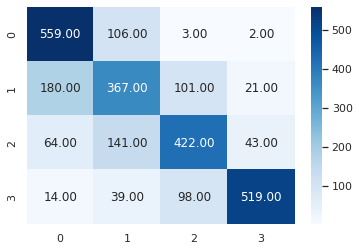

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.629339,0.657335,0.538261,0.541993,0.626726,0.621127,0.696902,0.696902,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.629768,0.654772,0.523542,0.525256,0.623836,0.606253,0.697839,0.696653,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,2.419872,0.978414,1.111082,1.056238,1.009560,0.927547,0.982474,0.953090,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
metrics(SVC_calib_grid.best_estimator_,X_test,y_test,'SVC_calib')
result_dataset

### Lets use decisiion trees

In [108]:
Dt_params = {'model__criterion': ['gini','entropy'],'model__max_depth' : [7,8,9,10,11,12,13,14,15]}
Dt_pipe = Pipeline([('gender_onehot', gender_onehot),('model', DecisionTreeClassifier())])
Dt_grid = GridSearchCV(estimator=Dt_pipe, param_grid=Dt_params,cv = 2,verbose = 2,scoring = 'accuracy')
Dt_grid.fit(X_train, y_train)
Dt_grid.best_estimator_

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END ..........model__criterion=gini, model__max_depth=7; total time=   0.0s
[CV] END ..........model__criterion=gini, model__max_depth=7; total time=   0.0s
[CV] END ..........model__criterion=gini, model__max_depth=8; total time=   0.0s
[CV] END ..........model__criterion=gini, model__max_depth=8; total time=   0.1s
[CV] END ..........model__criterion=gini, model__max_depth=9; total time=   0.0s
[CV] END ..........model__criterion=gini, model__max_depth=9; total time=   0.0s
[CV] END .........model__criterion=gini, model__max_depth=10; total time=   0.1s
[CV] END .........model__criterion=gini, model__max_depth=10; total time=   0.1s
[CV] END .........model__criterion=gini, model__max_depth=11; total time=   0.1s
[CV] END .........model__criterion=gini, model__max_depth=11; total time=   0.1s
[CV] END .........model__criterion=gini, model__max_depth=12; total time=   0.1s
[CV] END .........model__criterion=gini, model__

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
           

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10))])

In [109]:
Dt_grid.best_params_

{'model__criterion': 'entropy', 'model__max_depth': 10}

accuracy score : 0.6797312430011199
f1 score : 0.6746549808488582
log loss : 3.646868220949728
classification report : 
               precision    recall  f1-score   support

           0       0.65      0.89      0.75       670
           1       0.55      0.51      0.53       669
           3       0.70      0.54      0.61       670
           4       0.85      0.77      0.81       670

    accuracy                           0.68      2679
   macro avg       0.69      0.68      0.67      2679
weighted avg       0.69      0.68      0.67      2679

*********** confusion matrx ***********


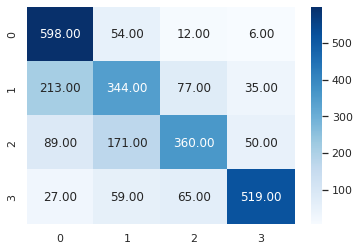

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.629339,0.657335,0.538261,0.541993,0.626726,0.621127,0.696902,0.696902,0.679731,0.0,0.0,0.0,0.0,0.0
f1_score,0.629768,0.654772,0.523542,0.525256,0.623836,0.606253,0.697839,0.696653,0.674655,0.0,0.0,0.0,0.0,0.0
log_loss,2.419872,0.978414,1.111082,1.056238,1.009560,0.927547,0.982474,0.953090,3.646868,0.0,0.0,0.0,0.0,0.0


In [110]:
metrics(Dt_grid.best_estimator_,X_test,y_test,'DT')
result_dataset

## Lets Use DT calibration

In [111]:
Dt_calib_params = {'model__method' : ['sigmoid', 'isotonic'],'model__base_estimator__criterion': ['gini','entropy'],'model__base_estimator__max_depth' : [7,8,9,10,11,12,13,14,15]}
Dt_calib_pipe = Pipeline([('gender_onehot', gender_onehot),('model', CalibratedClassifierCV(DecisionTreeClassifier()))])
Dt_calib_grid = GridSearchCV(estimator=Dt_calib_pipe, param_grid=Dt_calib_params,cv = 2,verbose = 2)
Dt_calib_grid.fit(X_train, y_train)
Dt_calib_grid.best_estimator_

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] END model__base_estimator__criterion=gini, model__base_estimator__max_depth=7, model__method=sigmoid; total time=   0.2s
[CV] END model__base_estimator__criterion=gini, model__base_estimator__max_depth=7, model__method=sigmoid; total time=   0.2s
[CV] END model__base_estimator__criterion=gini, model__base_estimator__max_depth=7, model__method=isotonic; total time=   0.2s
[CV] END model__base_estimator__criterion=gini, model__base_estimator__max_depth=7, model__method=isotonic; total time=   0.2s
[CV] END model__base_estimator__criterion=gini, model__base_estimator__max_depth=8, model__method=sigmoid; total time=   0.2s
[CV] END model__base_estimator__criterion=gini, model__base_estimator__max_depth=8, model__method=sigmoid; total time=   0.2s
[CV] END model__base_estimator__criterion=gini, model__base_estimator__max_depth=8, model__method=isotonic; total time=   0.2s
[CV] END model__base_estimator__criterion=gini, model_

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
           

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
                 CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                              max_depth=11),
                                        method='isotonic'))])

accuracy score : 0.7170586039567003
f1 score : 0.7149070074379797
log loss : 0.9177238773954857
classification report : 
               precision    recall  f1-score   support

           0       0.69      0.90      0.78       670
           1       0.60      0.58      0.59       669
           3       0.72      0.61      0.66       670
           4       0.89      0.78      0.83       670

    accuracy                           0.72      2679
   macro avg       0.72      0.72      0.71      2679
weighted avg       0.72      0.72      0.71      2679

*********** confusion matrx ***********


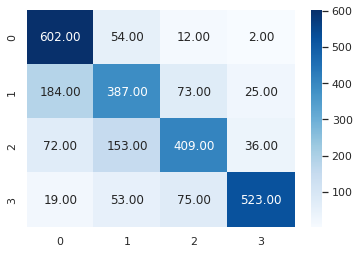

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.629339,0.657335,0.538261,0.541993,0.626726,0.621127,0.696902,0.696902,0.679731,0.717059,0.0,0.0,0.0,0.0
f1_score,0.629768,0.654772,0.523542,0.525256,0.623836,0.606253,0.697839,0.696653,0.674655,0.714907,0.0,0.0,0.0,0.0
log_loss,2.419872,0.978414,1.111082,1.056238,1.009560,0.927547,0.982474,0.953090,3.646868,0.917724,0.0,0.0,0.0,0.0


In [112]:
metrics(Dt_calib_grid.best_estimator_,X_test,y_test,'DT_calib')
result_dataset

### Lets Try Random Forest

In [114]:
RF_params = {'model__n_estimators' : [60,65,70,75,80,85,90,95],'model__criterion' : ['gini', 'entropy'],'model__max_depth' : [10,12,13,15]}
RF_pipe = Pipeline([('gender_onehot', gender_onehot),('model', RandomForestClassifier())])
RF_grid = GridSearchCV(estimator=RF_pipe, param_grid=RF_params,cv = 2,verbose = 2,scoring = 'accuracy')
RF_grid.fit(X_train, y_train)
RF_grid.best_estimator_

Fitting 2 folds for each of 64 candidates, totalling 128 fits
[CV] END model__criterion=gini, model__max_depth=10, model__n_estimators=60; total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=10, model__n_estimators=60; total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=10, model__n_estimators=65; total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=10, model__n_estimators=65; total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=10, model__n_estimators=70; total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=10, model__n_estimators=70; total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=10, model__n_estimators=75; total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=10, model__n_estimators=75; total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=10, model__n_estimators=80; total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=10, model__n_estimators=8

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
           

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
                 RandomForestClassifier(criterion='entropy', max_depth=13,
                                        n_estimators=80))])

In [115]:
RF_grid.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 13,
 'model__n_estimators': 80}

accuracy score : 0.7510265024262784
f1 score : 0.748154129695769
log loss : 0.8983385855048898
classification report : 
               precision    recall  f1-score   support

           0       0.70      0.92      0.80       670
           1       0.65      0.57      0.61       669
           3       0.76      0.68      0.72       670
           4       0.91      0.83      0.87       670

    accuracy                           0.75      2679
   macro avg       0.76      0.75      0.75      2679
weighted avg       0.76      0.75      0.75      2679

*********** confusion matrx ***********


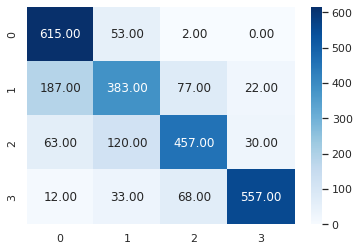

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.629339,0.657335,0.538261,0.541993,0.626726,0.621127,0.696902,0.696902,0.679731,0.717059,0.751027,0.0,0.0,0.0
f1_score,0.629768,0.654772,0.523542,0.525256,0.623836,0.606253,0.697839,0.696653,0.674655,0.714907,0.748154,0.0,0.0,0.0
log_loss,2.419872,0.978414,1.111082,1.056238,1.009560,0.927547,0.982474,0.953090,3.646868,0.917724,0.898339,0.0,0.0,0.0


In [116]:
metrics(RF_grid.best_estimator_,X_test,y_test,'RF')
result_dataset

## Lets Use RF calibration

In [118]:
RF_calib_params = {'model__method' : ['sigmoid', 'isotonic'],'model__base_estimator__n_estimators' : [75,80,85,90],'model__base_estimator__criterion' : ['entropy'],'model__base_estimator__max_depth' : [10,12,13]}
RF_calib_pipe = Pipeline([('gender_onehot', gender_onehot),('model', CalibratedClassifierCV(RandomForestClassifier()))])
RF_calib_grid = GridSearchCV(estimator=RF_calib_pipe, param_grid=RF_calib_params,cv = 2,verbose = 2)
RF_calib_grid.fit(X_train, y_train)
RF_calib_grid.best_estimator_

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] END model__base_estimator__criterion=entropy, model__base_estimator__max_depth=10, model__base_estimator__n_estimators=75, model__method=sigmoid; total time=   4.8s
[CV] END model__base_estimator__criterion=entropy, model__base_estimator__max_depth=10, model__base_estimator__n_estimators=75, model__method=sigmoid; total time=   4.9s
[CV] END model__base_estimator__criterion=entropy, model__base_estimator__max_depth=10, model__base_estimator__n_estimators=75, model__method=isotonic; total time=   4.7s
[CV] END model__base_estimator__criterion=entropy, model__base_estimator__max_depth=10, model__base_estimator__n_estimators=75, model__method=isotonic; total time=   4.7s
[CV] END model__base_estimator__criterion=entropy, model__base_estimator__max_depth=10, model__base_estimator__n_estimators=80, model__method=sigmoid; total time=   5.1s
[CV] END model__base_estimator__criterion=entropy, model__base_estimator__max_depth=10,

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
           

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
                 CalibratedClassifierCV(base_estimator=RandomForestClassifier(criterion='entropy',
                                                                              max_depth=13,
                                                                              n_estimators=75),
                                        method='isotonic'))])

accuracy score : 0.7506532288167227
f1 score : 0.7491521092351913
log loss : 0.9841540263792025
classification report : 
               precision    recall  f1-score   support

           0       0.71      0.90      0.79       670
           1       0.64      0.61      0.63       669
           3       0.77      0.66      0.71       670
           4       0.91      0.83      0.87       670

    accuracy                           0.75      2679
   macro avg       0.76      0.75      0.75      2679
weighted avg       0.76      0.75      0.75      2679

*********** confusion matrx ***********


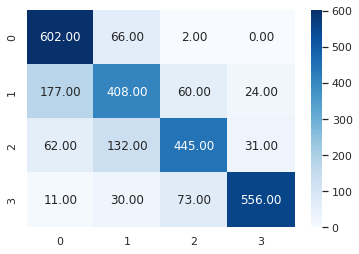

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.629339,0.657335,0.538261,0.541993,0.626726,0.621127,0.696902,0.696902,0.679731,0.717059,0.751027,0.750653,0.0,0.0
f1_score,0.629768,0.654772,0.523542,0.525256,0.623836,0.606253,0.697839,0.696653,0.674655,0.714907,0.748154,0.749152,0.0,0.0
log_loss,2.419872,0.978414,1.111082,1.056238,1.009560,0.927547,0.982474,0.953090,3.646868,0.917724,0.898339,0.984154,0.0,0.0


In [119]:
metrics(RF_calib_grid.best_estimator_,X_test,y_test,'RF_calib')
result_dataset

### Lets try GBDT

In [120]:
gbdt_params = {'model__loss' : ['log_loss', 'deviance', 'exponential'],'model__learning_rate' : [0.1,0.3,0.6,0.9],'model__n_estimators':[80,90,100,110]}
gbdt_pipe = Pipeline([('gender_onehot', gender_onehot),('model', GradientBoostingClassifier(random_state = 42))])
gbdt_grid = GridSearchCV(estimator=gbdt_pipe, param_grid=gbdt_params,cv = 2,verbose = 2,scoring = 'accuracy')
gbdt_grid.fit(X_train, y_train)
gbdt_grid.best_estimator_

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=80; total time=   0.0s
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=80; total time=   0.0s
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=90; total time=   0.0s
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=90; total time=   0.0s
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=100; total time=   0.0s
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=100; total time=   0.0s
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=110; total time=   0.0s
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=110; total time=   0.0s
[CV] END model__learning_rate=0.1, model__loss=deviance, model__n_estimators=80; total time=   4.0s
[CV] END model__learning_rate=0.1, 

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
           

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.3,
                                            random_state=42))])

In [122]:
gbdt_grid.best_params_

{'model__learning_rate': 0.3,
 'model__loss': 'deviance',
 'model__n_estimators': 100}

accuracy score : 0.7360955580440462
f1 score : 0.7349174775611343
log loss : 0.9991544893453795
classification report : 
               precision    recall  f1-score   support

           0       0.71      0.86      0.78       670
           1       0.61      0.58      0.60       669
           3       0.73      0.66      0.69       670
           4       0.91      0.84      0.87       670

    accuracy                           0.74      2679
   macro avg       0.74      0.74      0.73      2679
weighted avg       0.74      0.74      0.73      2679

*********** confusion matrx ***********


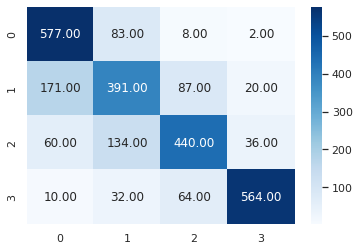

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.629339,0.657335,0.538261,0.541993,0.626726,0.621127,0.696902,0.696902,0.679731,0.717059,0.751027,0.750653,0.736096,0.0
f1_score,0.629768,0.654772,0.523542,0.525256,0.623836,0.606253,0.697839,0.696653,0.674655,0.714907,0.748154,0.749152,0.734917,0.0
log_loss,2.419872,0.978414,1.111082,1.056238,1.009560,0.927547,0.982474,0.953090,3.646868,0.917724,0.898339,0.984154,0.999154,0.0


In [123]:
metrics(gbdt_grid.best_estimator_,X_test,y_test,'GBDT')
result_dataset

## Lets Use GBDT calibration

In [125]:
gbdt_calib_params = {'model__method' : ['sigmoid', 'isotonic'],'model__base_estimator__loss' : ['deviance'],'model__base_estimator__learning_rate' : [0.3],'model__base_estimator__n_estimators':[100]}
gbdt_calib_pipe = Pipeline([('gender_onehot', gender_onehot),('model', CalibratedClassifierCV(GradientBoostingClassifier(random_state = 42)))])
gbdt_calib_grid = GridSearchCV(estimator=gbdt_calib_pipe, param_grid=gbdt_calib_params,cv = 2,verbose = 2)
gbdt_calib_grid.fit(X_train, y_train)
gbdt_calib_grid.best_estimator_

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END model__base_estimator__learning_rate=0.3, model__base_estimator__loss=deviance, model__base_estimator__n_estimators=100, model__method=sigmoid; total time=  20.6s
[CV] END model__base_estimator__learning_rate=0.3, model__base_estimator__loss=deviance, model__base_estimator__n_estimators=100, model__method=sigmoid; total time=  20.7s
[CV] END model__base_estimator__learning_rate=0.3, model__base_estimator__loss=deviance, model__base_estimator__n_estimators=100, model__method=isotonic; total time=  20.4s
[CV] END model__base_estimator__learning_rate=0.3, model__base_estimator__loss=deviance, model__base_estimator__n_estimators=100, model__method=isotonic; total time=  22.3s


Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
           

Pipeline(steps=[('gender_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('genderencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('remaining_scaling',
                                                  StandardScaler(),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm'])])),
                ('model',
                 CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(learning_rate=0.3,
                                                                                  random_state=42)))])

accuracy score : 0.7364688316536021
f1 score : 0.7344642851488173
log loss : 0.9434302213613653
classification report : 
               precision    recall  f1-score   support

           0       0.71      0.90      0.79       670
           1       0.61      0.56      0.58       669
           3       0.72      0.66      0.69       670
           4       0.93      0.83      0.87       670

    accuracy                           0.74      2679
   macro avg       0.74      0.74      0.73      2679
weighted avg       0.74      0.74      0.73      2679

*********** confusion matrx ***********


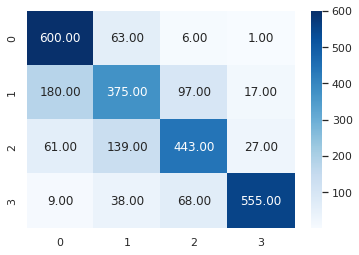

,KNN,KNN_calib,NB,NB_calib,LR,LR_calib,SVC,SVC_calib,DT,DT_calib,RF,RF_calib,GBDT,GBDT_calib
accuracy_score,0.629339,0.657335,0.538261,0.541993,0.626726,0.621127,0.696902,0.696902,0.679731,0.717059,0.751027,0.750653,0.736096,0.736469
f1_score,0.629768,0.654772,0.523542,0.525256,0.623836,0.606253,0.697839,0.696653,0.674655,0.714907,0.748154,0.749152,0.734917,0.734464
log_loss,2.419872,0.978414,1.111082,1.056238,1.009560,0.927547,0.982474,0.953090,3.646868,0.917724,0.898339,0.984154,0.999154,0.943430


In [126]:
metrics(gbdt_calib_grid.best_estimator_,X_test,y_test,'GBDT_calib')
result_dataset